# Part 1

## Part 1: Question 1

a) The parameters required for the execution of both algorithms are: 1. To nucleotide or amino acid sequences to align. 2. A similarity matrix to score individual pairwise alignments. 3. A gap opening cost and a gap extension cost in the affine gap case.

NW global alignment traceback begins in the lower right hand corner of the traceback matrix and continues until the upper left hand corner is reached (if your algorithm considers overhangs as gaps). The first row and column of the traceback matrix are subject to the gap penalty. Alignment scores in NW can be zero. Multiple equivalent score global alignments may be achieved.

SW local alignment traceback begins at the indices of the maximum score/s in the score matrix. Traceback occurs until a score value of zero is reached. Negative scoring values generated in the alignment procedure are set to zero. The first row and column of the traceback matrix are set to zero. Multiple equivalent score local alignments may be achieved.

b) The primary quantities return are the alignment score/s and a visual representation of the alignment/s. A score matrix and a traceback matrix are also generated and may be returned.

c) The runtime complexity for both algorithms are O(mn)

## Part 1: Question 2

Most functionality between the algorithms are identical, but there are a few key differences.

1. The first row and column are initialized with the gap penalty in NW, while the first row and column are filled with zeros in SW.

2. When generating the score matrix, values in SW are set to zero if they are negative, while values in NW are allowed to be negative.

3. Lastly, NW traceback begins at the bottom right hand corner of the traceback matrix until the top left hand corner matrix is reached. SW traceback begins at the indices of the maximum score/s in the score matrix. Traceback occurs until a score value of zero is reached.

## Part 1: Question 3

Affine gap implementation requires you to consider the history of the scoring procedure, whether a match, a gap in sequence 1, or a gap in sequence 2 was previously selected. This is required as you need to know if a gap is being opened or extended in order to apply the appropriate penalty. This is not required when a linear gap cost is implemented.

## Part 1: Question 4

I auto-generated a README.md file detailing the API using Pydoc-Markdown.

# Part 2

In [1]:
# Imports

import os
import pickle
import operator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from notebook_util import paired_file_reader, align_score_gen, pred_gen, \
                          pr_calc, save_obj, load_obj

In [2]:
# Set data path

base_path = os.getcwd() + '/'
scoring_path = base_path + 'scoring_matrices/'
sequence_path = base_path + 'sequences/'

## Part 2: Question 1

In [3]:
# Generate lists of pair filenames

pos_pairs = paired_file_reader(scoring_path + 'Pospairs.txt')
neg_pairs = paired_file_reader(scoring_path + 'Negpairs.txt')

In [4]:
# Set alignment parameters

gap = 11, 3
sim_matrix = scoring_path + 'BLOSUM50.mat'

In [5]:
# Generate local alignment scores

pos_scores = align_score_gen(pos_pairs, sim_matrix, gap, 'sw', base_path)
neg_scores = align_score_gen(neg_pairs, sim_matrix, gap, 'sw', base_path)

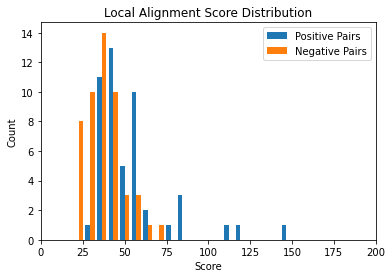

In [6]:
# Plot histogram of alignment scores

plt.hist([pos_scores, neg_scores], bins=50, 
         label=['Positive Pairs', 'Negative Pairs'])
plt.xlim(0, 200)
plt.legend(loc='upper right')
plt.title('Local Alignment Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

The distributions appear normal with long tails extending with increasing alignment scores. The distributions have a large overlap in the range of 30-60.

## Part 2: Question 2

In [7]:
# Calculate the threshold of the confustion matric

all_scores = pos_scores + neg_scores
cm_thresh = np.mean(all_scores)
print(f'Threshold Value = {cm_thresh:.2f}')

Threshold Value = 48.44


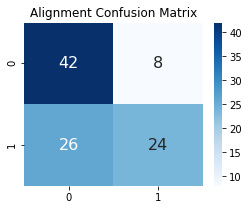

In [8]:
# Determine predicted and actual classifications 
# and caclulate the confusion matrix

# Generate predicted classification
pred = []
for value in all_scores:
    if value >= cm_thresh:
        pred.append(1)
    else:
        pred.append(0)

# Generate actual classification
actual = [1]*len(pos_scores) + [0]*len(neg_scores)

# Calculate confusion matrix
cm = confusion_matrix(actual, pred)
tn, fp, fn, tp = cm.ravel()
plt.figure(figsize=[4,3])
sns.heatmap(cm, annot=True, cmap='Blues', annot_kws={"size": 16})
plt.title('Alignment Confusion Matrix')
plt.show()

The threshold value is 48.44. The large number of true negatives to false positives (42:8) suggests that the algorithm does a good job classifying negative alignments for this threshold value. The rate of true positives to false negatives (24:26) is nearly one to one, suggesting that the algorithm does a poor job classifying positive alignments at this threshold value.

## Part 2: Question 3

In [9]:
# Calculate predictions over a range of thresholds

pred_list = pred_gen(all_scores)

In [10]:
# Calculate true positve and false positive rates

tpr, fpr = pr_calc(actual, pred_list)

Text(0, 0.5, 'True Positive Rate')

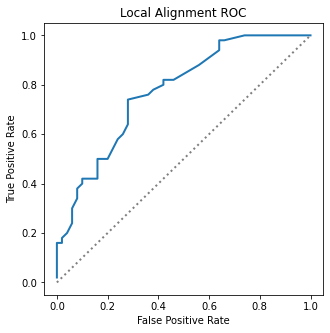

In [11]:
# Plot the ROC curve

plt.figure(figsize=[5,5])
plt.plot(fpr, tpr, color='C0', lw=2)
plt.plot([0, 1], [0, 1], color='C7', lw=2, linestyle=':')
plt.title('Local Alignment ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Part 2: Question 4

In [12]:
# Calculate area under the ROC curve

print(f'AUROC = {auc(fpr, tpr):.3f}')

AUROC = 0.773


In our case, the AUROC value measures the probability the model will correctly identify a positive alignment as positive. This metric is often used to compare different models, or simply to compare model performance to random chance.

AUROC should not be used as your only model metric, as it has some weaknesses. One weakness is that it equally weighs false positives and false negatives, while the model user may prefer to bias either false positives or false negatives. Further, in some cases there are portions of the ROC space that are not relevant for the modeler, and partial AUROC should be utilized instead. Other metrics, such as the Brier score, should be used in tandem with AUROC to better qualify your prediction model.

## Part 2: Question 5

In [13]:
# Generate local alignment scores over gap opening and gap extension 
# penalties ranging from 1-20 and 1-5 respectively

gap = 0, 0
sim_matrix = scoring_path + 'BLOSUM62.mat'
all_scores_dict = {}

for i in range(1,21):
    for j in range(1,6):
        gap = i, j
        
        pos_scores = align_score_gen(pos_pairs, sim_matrix, 
                                     gap, 'sw', base_path)
        neg_scores = align_score_gen(neg_pairs, sim_matrix, 
                                     gap, 'sw', base_path)
        
        all_scores_dict[i,j] = pos_scores + neg_scores

# Save dict as .pkl file
save_obj(all_scores_dict, 'all_scores_dict')

In [14]:
# Import previously generated dict if needed

all_scores_dict = load_obj('all_scores_dict')

In [15]:
# Genrate dict of the predicted classes from the score dict

pred_dict = {}

for i in range(1,21):
    for j in range(1,6):
        pred_list = pred_gen(all_scores_dict[i,j])
        pred_dict[i,j] = pred_list

In [16]:
# Generate ROAUC scores for all predictions

auc_dict = {}

for i in range(1,21):
    for j in range(1,6):
        tpr, fpr = pr_calc(actual, pred_dict[i,j])
        auc_dict[i,j] = auc(fpr, tpr)

In [17]:
# Identify gap penality resculting in highest the AUROC

best_gap = max(auc_dict.items(), key=operator.itemgetter(1))[0]
print(f'Gap Opening = {best_gap[0]:.0f} Gap Extension = {best_gap[1]:.0f}')

Gap Opening = 4 Gap Extension = 4


The lower gap opening cost (relative to the range tested) suggests that insertions and deletions are common in evolution and may occur frequently while still conserving the overall protein sequence. The fact that the gap opening cost is equal to the gap extension cost may speak to the fact that overall sequences are better conserved when gaps are smaller rather than larger.

## Part 2: Question 6

In [18]:
# Calulate global alignment ROC and AUC values for all matrices

gap = best_gap
name_list = ['BLOSUM50', 'BLOSUM62', 'PAM100', 'PAM250']
global_roc_dict = {}

for name in name_list:
        matrix = scoring_path + name + '.mat'
        pos_scores = align_score_gen(pos_pairs, matrix, 
                                     gap, 'nw', base_path)
        neg_scores = align_score_gen(neg_pairs, matrix, 
                                     gap, 'nw', base_path)
        
        pred_list = pred_gen(pos_scores + neg_scores)
        
        tpr, fpr = pr_calc(actual, pred_list)
        global_roc_dict[name] = fpr, tpr
        global_roc_dict[name + 'AUC'] = auc(fpr, tpr)

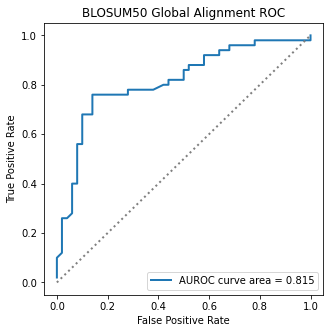

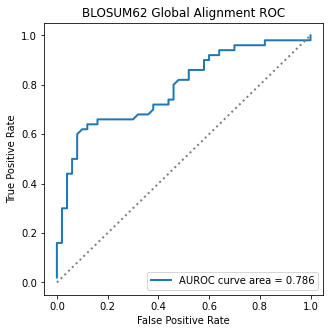

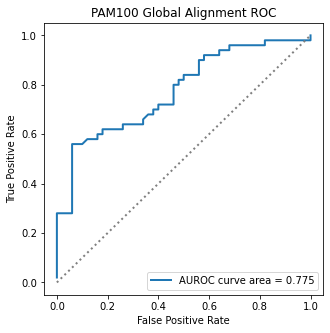

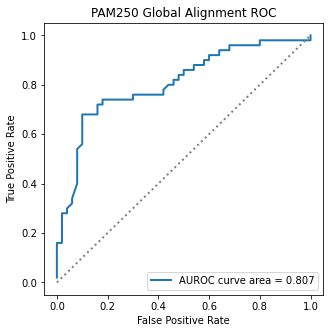

In [19]:
# Plot the ROC curves and AUC values

for name in name_list:
    plt.figure(figsize=[5,5])
    plt.plot(global_roc_dict[name][0], global_roc_dict[name][1], 
             color='C0', lw=2, label=f'AUROC curve area = %0.3f'  % global_roc_dict[name + 'AUC'])
    plt.plot([0, 1], [0, 1], color='C7', lw=2, linestyle=':')
    plt.title(name + ' Global Alignment ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

## Part 2: Question 7

In [20]:
# Calulate local alignment ROC and AUC values for all matrices

gap = best_gap
name_list = ['BLOSUM50', 'BLOSUM62', 'PAM100', 'PAM250']
local_roc_dict = {}

for name in name_list:
        matrix = scoring_path + name + '.mat'
        pos_scores = align_score_gen(pos_pairs, matrix, 
                                     gap, 'sw', base_path)
        neg_scores = align_score_gen(neg_pairs, matrix, 
                                     gap, 'sw', base_path)
        
        pred_list = pred_gen(pos_scores + neg_scores)
        
        tpr, fpr = pr_calc(actual, pred_list)
        local_roc_dict[name] = fpr, tpr
        local_roc_dict[name + 'AUC'] = auc(fpr, tpr)

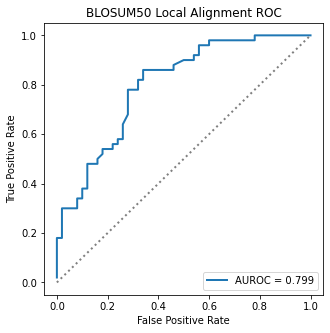

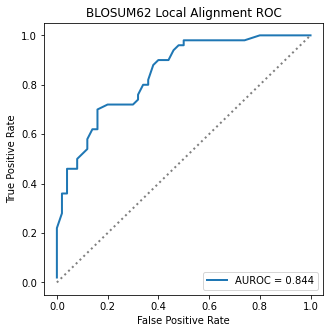

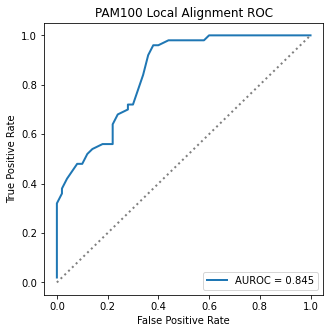

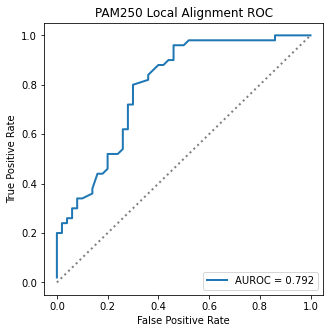

In [21]:
# Plot the ROC curves and AUC values

for name in name_list:
    plt.figure(figsize=[5,5])
    plt.plot(local_roc_dict[name][0], local_roc_dict[name][1], 
             color='C0', lw=2, label=f'AUROC = %0.3f'  % local_roc_dict[name + 'AUC'])
    plt.plot([0, 1], [0, 1], color='C7', lw=2, linestyle=':')
    plt.title(name + ' Local Alignment ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

The best performing algorithm by AUROC is Smith-Waterman.

## Part 2: Question 8

As the most predictive algorithm over the range of similarity matrices was Smith-Waterman, it's likely that insertions and deletions are common in evolution, but these mutations often do not disrupt the overall sequence of the protein.